# Pytorch框架中的深度学习计算结构

## 网络结构中的层和块

In [1]:
#导入第三方库
import torch 
from torch import nn
from torch.nn import functional as F

In [2]:
#通过实例化nn.Sequential来构建模型
net = nn.Sequential(nn.Linear(20, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))
X = torch.rand(2, 20)
net(X)

tensor([[ 0.0248,  0.1408,  0.1369, -0.0893,  0.1537,  0.1310,  0.0844,  0.0005,
          0.0606,  0.0400],
        [ 0.0822,  0.0404,  0.1695, -0.0884, -0.0213, -0.0057, -0.0190,  0.1623,
         -0.1306,  0.0568]], grad_fn=<AddmmBackward0>)

自定义块
总结每个块必须提供的基本功能：
- 将输入数据作为其前向传播函数的参数
- 通过前向传播函数生成输出(输出形状可能与输入形状不一样)
- 计算其输出关于输入的梯度，可通过其反向传播函数进行访问
- 存储和访问前向传播计算所需的参数
- 根据需要初始化模型参数

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256) #定义隐藏层
        self.out = nn.Linear(256, 10) #定义输出层
    
    def forward(self, X):
        #使用ReLU的函数版本，在nn.functional中有定义
        return self.out(F.relu(self.hidden(X)))

In [4]:
#系统自动生成反向传播函数和模型初始参数
net = MLP()
net(X)

tensor([[-0.2032,  0.0129, -0.0927, -0.0078, -0.0738,  0.1043,  0.0036, -0.3136,
          0.3234, -0.1957],
        [-0.0863,  0.0734,  0.1281, -0.1186,  0.0332,  0.0637,  0.0841, -0.2352,
          0.0965, -0.1881]], grad_fn=<AddmmBackward0>)

顺序快：为了实现Sequential类的工作原理，我们需要定义两个关键函数
- 一种将块逐个追加到列表中的函数
- 一种前向传播函数，用于将输入按追加块的顺序传递给块组成的链条

In [5]:
#实现MySequential类
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            #这里, module是Module子类的一个实例，我们把它保存在'Module'类的成员
            #变量_modules中，类型是OrderedDict
            self._modules[str(idx)] = module
    
    def forward(self, X):
        #OrderedDict保证了按照成员顺序遍历
        for block in self._modules.values():
            X = block(X)
        return X

In [6]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.2205,  0.3340, -0.2080,  0.0956, -0.2993, -0.0747, -0.1618, -0.1319,
         -0.0458,  0.3489],
        [ 0.2056,  0.2681, -0.1411,  0.1766, -0.2954, -0.0431, -0.0961, -0.1180,
          0.0360,  0.3510]], grad_fn=<AddmmBackward0>)

In [7]:
#在前向传播函数中执行代码，实现FixedHiddenMLP类
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        #不计算梯度的随机权重参数，不进行参数更新
        self.rand_weight = torch.rand((20, 20), requires_grad= False)
        self.linear = nn.Linear(20, 20)
    
    def forward(self, X):
        X = self.linear(X)
        #使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X , self.rand_weight) + 1)
        X = self.linear(X)
        #控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In [8]:
net = FixedHiddenMLP()
net(X)

tensor(0.1761, grad_fn=<SumBackward0>)

In [9]:
#混合搭配各种组合块的用法
class NestMLP(nn.Module):
    def __init__(self):
        #继承父类的初始化方法
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 32),
                                 nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.0830, grad_fn=<SumBackward0>)

## 参数管理

- 访问参数，用于调试、诊断和可视化
- 参数初始化
- 在不同的模型之间共享模型参数

In [10]:
#从已有模型中访问参数
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size= (2, 4))
net(X)

tensor([[0.3927],
        [0.3488]], grad_fn=<AddmmBackward0>)

In [11]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.0823,  0.1919, -0.1481,  0.0930,  0.3221,  0.2670,  0.1492,  0.0610]])), ('bias', tensor([0.1896]))])


In [12]:
#返回输出层偏置的参数类型
print(type(net[2].bias))
#返回输出层偏置：数据和是否加入梯度
print(net[2].bias)
#返回输出层偏置的数据
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.1896], requires_grad=True)
tensor([0.1896])


In [13]:
net[2].weight.grad == None

True

In [14]:
#一次性访问所有参数
print(*[(name, param.shape)for name, param in net[0].named_parameters()])
print(*[(name, param.shape)for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [15]:
#提供另一种访问网络参数的方式
net.state_dict()['2.bias'].data

tensor([0.1896])

In [16]:
#从嵌套块收集参数
#定义一个生成块的函数
def block1():
    return nn.Sequential(nn.Linear(4, 8),
                         nn.ReLU(),
                         nn.Linear(8, 4),
                         nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        #进行嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.4348],
        [-0.4347]], grad_fn=<AddmmBackward0>)

In [17]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


In [18]:
#可以像通过嵌套列表索引一样访问它们
rgnet[0][1][2].bias.data
rgnet[0][2][2].weight

Parameter containing:
tensor([[-0.2898, -0.1571,  0.2539, -0.2455, -0.0478, -0.1230,  0.0650, -0.1367],
        [-0.2552,  0.0322,  0.3373, -0.3224,  0.2590, -0.1690,  0.2865, -0.0406],
        [-0.2104, -0.2996, -0.3508, -0.2571,  0.3326,  0.1815, -0.2780,  0.1803],
        [-0.2460, -0.1741, -0.2263, -0.0849,  0.2154, -0.1314,  0.0256,  0.1260]],
       requires_grad=True)

In [19]:
#参数初始化
#内置初始化，将所有权重参数初始化为标准差为0.01的高斯随机变量，且将偏置参数设置为0
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean= 0, std= 0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0030, -0.0032,  0.0058, -0.0266]), tensor(0.))

In [20]:
#可以通过consta_方法将所有参数初始化为给定的常数，如1
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [21]:
#对某些块应用不同的初始化方法
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
net[0].weight.data[0], net[2].weight.data

(tensor([-0.1085, -0.3265,  0.4310, -0.6331]),
 tensor([[42., 42., 42., 42., 42., 42., 42., 42.]]))

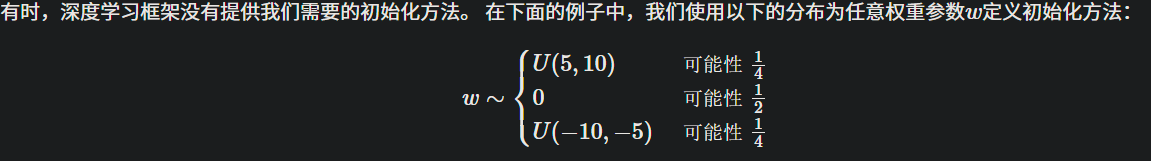

In [22]:
#自定义初始化
#实现my_init函数来应用到net
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])

        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 7.1936, -5.4898,  0.0000,  0.0000],
        [ 0.0000, -0.0000, -8.1200, -0.0000]], grad_fn=<SliceBackward0>)

In [23]:
#可以直接设置参数
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, -4.4898,  1.0000,  1.0000])

In [24]:
#参数绑定
#有时我们希望在多个层之间共享参数，我们可以定义一个稠密层，然后使用它来设置另一层的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), 
                    nn.ReLU(),
                    shared,
                    nn.ReLU(),
                    shared,
                    nn.ReLU(),
                    nn.Linear(8, 1))

net(X)
#检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
#确保它们实际上是同一个对象，而不只是有相同的值
net[2].weight.data[0,0] = 100
print(net[2].weight.data[0] == net[4].weight.data[0])


tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


## 延后初始化

好处：
- 延迟确定参数形状
- 提高模型灵活性
- 避免不必要的计算开销
- 防止输入形状错误

In [27]:
net = nn.Sequential(nn.LazyLinear(256), #使用延后初始化，不需要在定义时期提供输入特征的大小
                    nn.ReLU(),
                    nn.Linear(256, 10))
print(net)

#遍历参数中的每一层，并调用state_dict()方法查看参数状态
#没有进行参数初始化，参数为空
[net[i].state_dict() for i in range(len(net))]

#获取浮点类型的信息，包括最小值和最大值
low = torch.finfo(torch.float32).min / 10
high = torch.finfo(torch.float32).max / 10
#生成一个形状为[2, 20]的张量，其值在low和high之间均匀分布
X = torch.zeros([2, 20], dtype= torch.float32).uniform_(low, high)
print(net(X))


Sequential(
  (0): LazyLinear(in_features=0, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)
tensor([[-7.0544e+36, -9.9266e+36,  4.0856e+36,  2.3652e+36, -5.4403e+35,
          3.7961e+36,  3.6791e+36,  4.1105e+36, -5.9173e+36,  3.1280e+36],
        [-6.3568e+36, -2.0944e+36,  6.3188e+36, -8.5678e+35,  5.2777e+36,
          1.5080e+36,  7.1370e+36,  1.8701e+36, -4.9168e+36,  6.5327e+36]],
       grad_fn=<AddmmBackward0>)


## 自定义层

In [28]:
#构建不带参数的层
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

In [30]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [41]:
#将层作为组件合并到更复杂的模型中
net = nn.Sequential(nn.Linear(8, 128),
                    CenteredLayer())

#随机均分分布
Y = net(torch.rand(4, 8))
Y.mean()

tensor(-4.6566e-10, grad_fn=<MeanBackward0>)

In [44]:
#带参数层
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        #随机标准正态分布
        self.weight = nn.Parameter(torch.randn(in_units, units))
        #bias为1D张量
        self.bias = nn.Parameter(torch.randn(units,))
    
    def forward(self, X):
        '''
        手动实现线性回归并使用激活函数
        '''
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

In [45]:
#实例化MyLinear类并访问其模型参数
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-1.3290, -0.4822, -0.4800],
        [-0.8942, -0.6647,  0.2024],
        [-1.2151,  0.7784,  0.0491],
        [ 0.6760, -1.3739, -0.3555],
        [-0.4167,  0.0892, -0.5154]], requires_grad=True)

In [49]:
#使用自定义层直接执行前向传播计算
linear(torch.randn(2, 5))

tensor([[1.6373, 0.0000, 0.0000],
        [0.0000, 2.2910, 0.0000]])

In [50]:
#使用自定义层构建模型
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.randn(2, 64))

tensor([[15.7768],
        [18.5141]])